In [0]:
pip install openai pandas hdbscan plotly python-dotenv umap-learn langchain langchain_community openTSNE -q

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:

#general
import numpy as np
import pandas as pd
from ast import literal_eval
from dotenv import load_dotenv

#LLM y embeddings
from openai import AzureOpenAI

#graficar
import matplotlib.pyplot as plt
import plotly.express as px

#Modelos
from sklearn.cluster import DBSCAN, KMeans
import hdbscan
from umap import UMAP
from sklearn.decomposition import PCA
import openTSNE
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

#metricas
from sklearn.manifold import trustworthiness
from sklearn.metrics import make_scorer, silhouette_score

load_dotenv()

True

In [0]:
%run /Workspace/Users/arestrepo15@summa-sci.com/proyecto_integrador/connection_datalake

## cargar dataset con embeddings

In [0]:
path = "df_split_250_embeddings_videos_youtube.csv"
file_path = f"abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/{path}"
df_youtube_data = spark.read.option("header", True) \
                           .option("inferSchema", True) \
                           .option("sep", ";") \
                           .csv(file_path)

[FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings.csv', name='dataset_videos_youtube_embeddings.csv', size=689874729, modificationTime=1715291158000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings_300_tokens.csv', name='dataset_videos_youtube_embeddings_300_tokens.csv', size=1924220793, modificationTime=1717730763000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/dataset_videos_youtube_embeddings_500_tokens.csv', name='dataset_videos_youtube_embeddings_500_tokens.csv', size=1292213144, modificationTime=1717730158000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/df_curated_videos_youtube.csv', name='df_curated_videos_youtube.csv', size=91124952, modificationTime=1717729824000),
 FileInfo(path='abfss://presentation@sadatalakeproyecto.dfs.core.windows.net/df_split_250_embeddings_videos_youtube.csv', n

In [0]:
df_data = df_youtube_data.toPandas()
df_data.head()

,chanel_name,video_id,publish_date,title,year,text,chunk_part,embedding
0,Bolsas hoy,ij6gk-ljur0,2023-12-30,bitcoin y sp500 reaccionan mal a refugios larg...,2023,bitcoin y sp500 reaccionan mal a refugios larg...,0,"[-0.01904446631669998, -0.01549495942890644, 0..."
1,Bolsas hoy,ij6gk-ljur0,2023-12-30,bitcoin y sp500 reaccionan mal a refugios larg...,2023,un potencial al alza de un un 30% antes de con...,1,"[-0.014547299593687057, -0.029706276953220367,..."
2,Bolsas hoy,ij6gk-ljur0,2023-12-30,bitcoin y sp500 reaccionan mal a refugios larg...,2023,bolsa este este año a partir del martes empeza...,2,"[-0.024475552141666412, -0.028507299721240997,..."
3,Bolsas hoy,ij6gk-ljur0,2023-12-30,bitcoin y sp500 reaccionan mal a refugios larg...,2023,nada importante donde los mercados donde perdó...,3,"[-0.019775763154029846, -0.017241820693016052,..."
4,Bolsas hoy,ij6gk-ljur0,2023-12-30,bitcoin y sp500 reaccionan mal a refugios larg...,2023,el cierre prácticamente han estado ahí no ha h...,4,"[-0.011368482373654842, -0.01605202443897724, ..."


## Adecuar embeddings para ser usados como predictores de los modelos

In [0]:
# Predictores embeddings
X = np.array([np.array(literal_eval(x), dtype=float) for x in df_data["embedding"].values] )

In [0]:
X.shape

(59073, 1536)

## Reduccion de dimensionalidad

### PCA

In [0]:
# Aplicar PCA
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(X)

# Visualizar la varianza explicada por los componentes principales
varianza_explicada = pca.explained_variance_ratio_
print("Varianza explicada por cada componente principal:", varianza_explicada)

Varianza explicada por cada componente principal: [0.06569726 0.03822158]


Aplicar pca, con todos los predictores para mirar cuantos componenetes se requieren para explicar la maxima variavilidad.

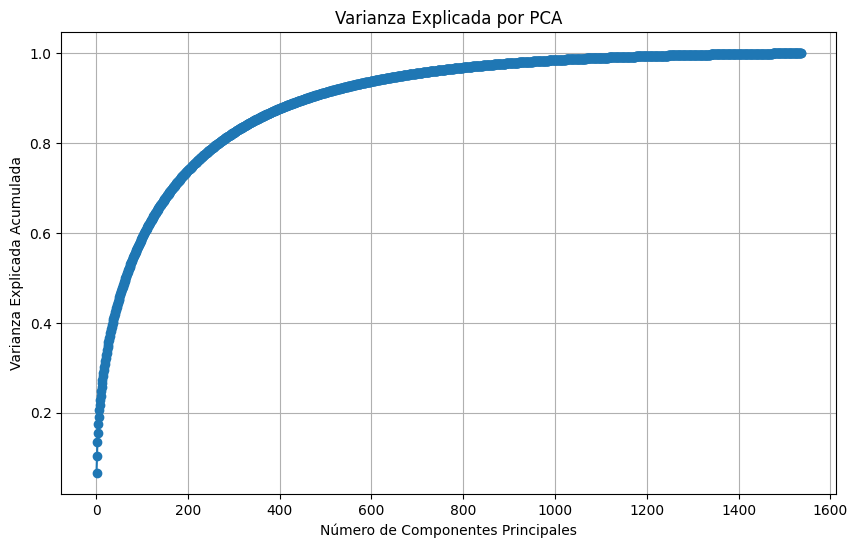

In [0]:
# Aplicación de PCA 
pca = PCA()
pca.fit(X)

# Cálculo de la varianza explicada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot de la varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA')
plt.grid(True)
plt.show()

### TSNE

In [0]:
tsne_model= TSNE(n_components=2, random_state=42, perplexity=3, metric='cosine')
reduced_X_tsne= tsne_model.fit_transform(X)

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Para t-SNE (t-distributed Stochastic Neighbor Embedding) es importante utilizar métricas que evalúen la preservación de la estructura de los datos en lugar de la varianza explicada. 

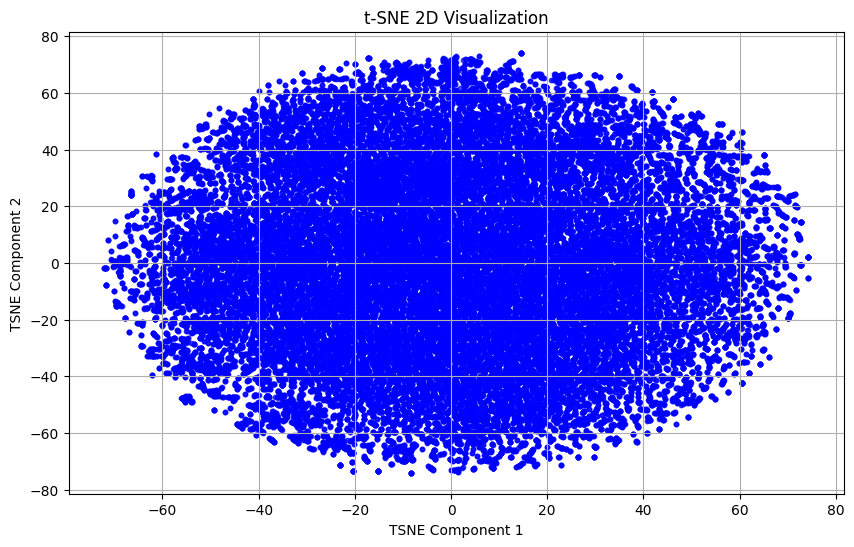

In [0]:
# Visualización de los datos reducidos
plt.figure(figsize=(10, 6))
plt.scatter(reduced_X_tsne[:, 0], reduced_X_tsne[:, 1], c='blue', marker='o', s=10, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE 2D Visualization')
plt.grid(True)
plt.show()

In [0]:
# calculating PCA on a PCA representation
init = openTSNE.initialization.rescale(X[:, :2])

In [0]:
aff100 = openTSNE.affinity.PerplexityBasedNN(
    X,
    perplexity=100,
    n_jobs=32,
    random_state=0,
)

In [0]:
aff400 = openTSNE.affinity.PerplexityBasedNN(
    X,
    perplexity=400,
    n_jobs=32,
    random_state=0,
)

In [0]:
aff800 = openTSNE.affinity.PerplexityBasedNN(
    X,
    perplexity=800,
    n_jobs=32,
    random_state=0,
)

In [0]:
aff1000 = openTSNE.affinity.PerplexityBasedNN(
    X,
    perplexity=1000,
    n_jobs=32,
    random_state=0,
)

In [0]:
embedding_standard = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff100, initialization=init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=4922.75 for 250 iterations...
Iteration   50, KL divergence 5.8555, 50 iterations in 2.7390 sec
Iteration  100, KL divergence 5.7340, 50 iterations in 2.7895 sec
Iteration  150, KL divergence 5.7298, 50 iterations in 2.7761 sec
Iteration  200, KL divergence 5.7308, 50 iterations in 2.7956 sec
Iteration  250, KL divergence 5.7239, 50 iterations in 2.7538 sec
   --> Time elapsed: 13.85 seconds
===> Running optimization with exaggeration=1.00, lr=59073.00 for 500 iterations...
Iteration   50, KL divergence 3.7156, 50 iterations in 2.7333 sec
Iteration  100, KL divergence 3.5999, 50 iterations in 3.0569 sec
Iteration  150, KL divergence 3.5546, 50 iterations in 3.8650 sec
Iteration  200, KL divergence 3.5294, 50 iterations in

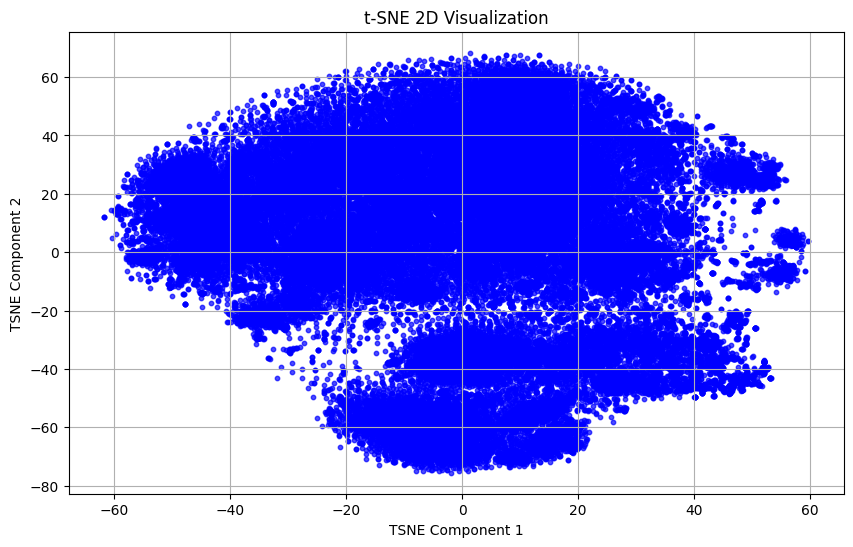

In [0]:
# Visualización de los datos reducidos
plt.figure(figsize=(10, 6))
plt.scatter(embedding_standard[:, 0], embedding_standard[:, 1], c='blue', marker='o', s=10, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE 2D Visualization')
plt.grid(True)
plt.show()

In [0]:
embedding_standard_2 = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff400, initialization=init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=4922.75 for 250 iterations...
Iteration   50, KL divergence 4.6300, 50 iterations in 5.7552 sec
Iteration  100, KL divergence 4.5106, 50 iterations in 5.8195 sec
Iteration  150, KL divergence 4.5137, 50 iterations in 5.8124 sec
Iteration  200, KL divergence 4.5137, 50 iterations in 5.7917 sec
Iteration  250, KL divergence 4.5144, 50 iterations in 5.8060 sec
   --> Time elapsed: 28.99 seconds
===> Running optimization with exaggeration=1.00, lr=59073.00 for 500 iterations...
Iteration   50, KL divergence 2.9496, 50 iterations in 5.7493 sec
Iteration  100, KL divergence 2.8854, 50 iterations in 5.7416 sec
Iteration  150, KL divergence 2.8681, 50 iterations in 6.2294 sec
Iteration  200, KL divergence 2.8599, 50 iterations in

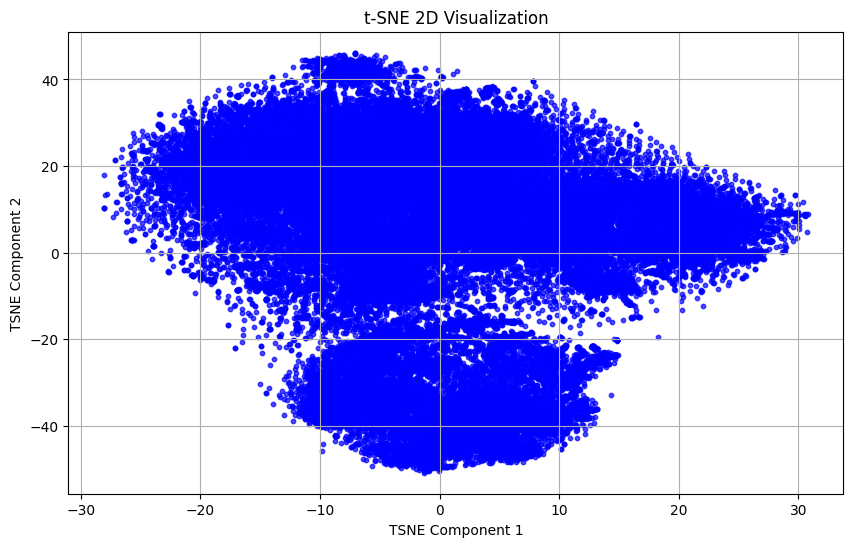

In [0]:
# Visualización de los datos reducidos
plt.figure(figsize=(10, 6))
plt.scatter(embedding_standard_2[:, 0], embedding_standard_2[:, 1], c='blue', marker='o', s=10, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE 2D Visualization')
plt.grid(True)
plt.show()

In [0]:
embedding_standard_3 = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff800, initialization=init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=4922.75 for 250 iterations...
Iteration   50, KL divergence 3.9723, 50 iterations in 9.8503 sec
Iteration  100, KL divergence 3.9516, 50 iterations in 9.7092 sec
Iteration  150, KL divergence 3.9127, 50 iterations in 9.7861 sec
Iteration  200, KL divergence 3.9128, 50 iterations in 9.8728 sec
Iteration  250, KL divergence 3.9125, 50 iterations in 9.7098 sec
   --> Time elapsed: 48.93 seconds
===> Running optimization with exaggeration=1.00, lr=59073.00 for 500 iterations...
Iteration   50, KL divergence 2.4714, 50 iterations in 9.6382 sec
Iteration  100, KL divergence 2.4397, 50 iterations in 9.5883 sec
Iteration  150, KL divergence 2.4330, 50 iterations in 9.7168 sec
Iteration  200, KL divergence 2.4311, 50 iterations in

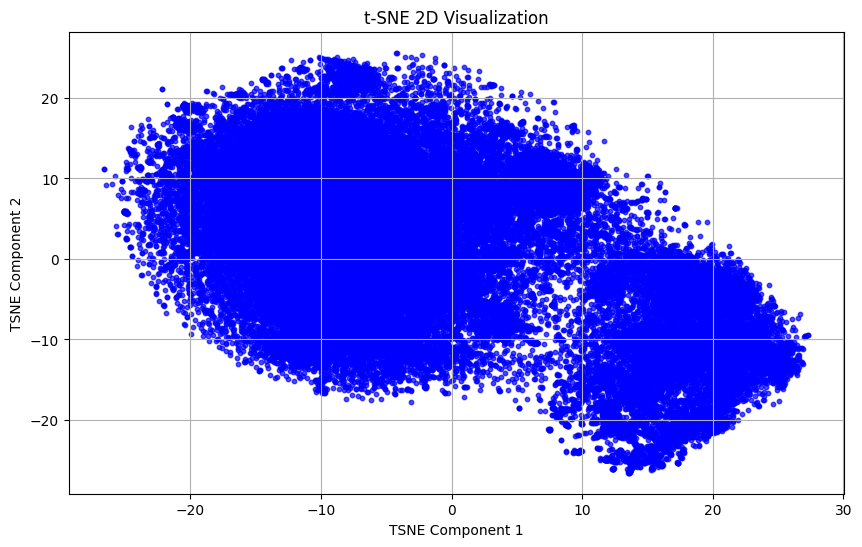

In [0]:
# Visualización de los datos reducidos
plt.figure(figsize=(10, 6))
plt.scatter(embedding_standard_3[:, 0], embedding_standard_3[:, 1], c='blue', marker='o', s=10, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE 2D Visualization')
plt.grid(True)
plt.show()

In [0]:
embedding_standard_4 = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff1000, initialization=init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=4922.75 for 250 iterations...
Iteration   50, KL divergence 3.7562, 50 iterations in 11.7381 sec
Iteration  100, KL divergence 3.7541, 50 iterations in 11.5306 sec
Iteration  150, KL divergence 3.7231, 50 iterations in 11.3945 sec
Iteration  200, KL divergence 3.7216, 50 iterations in 11.4622 sec
Iteration  250, KL divergence 3.7223, 50 iterations in 11.5226 sec
   --> Time elapsed: 57.65 seconds
===> Running optimization with exaggeration=1.00, lr=59073.00 for 500 iterations...
Iteration   50, KL divergence 2.3357, 50 iterations in 11.6639 sec
Iteration  100, KL divergence 2.3088, 50 iterations in 11.5615 sec
Iteration  150, KL divergence 2.3044, 50 iterations in 11.4353 sec
Iteration  200, KL divergence 2.3037, 50 itera

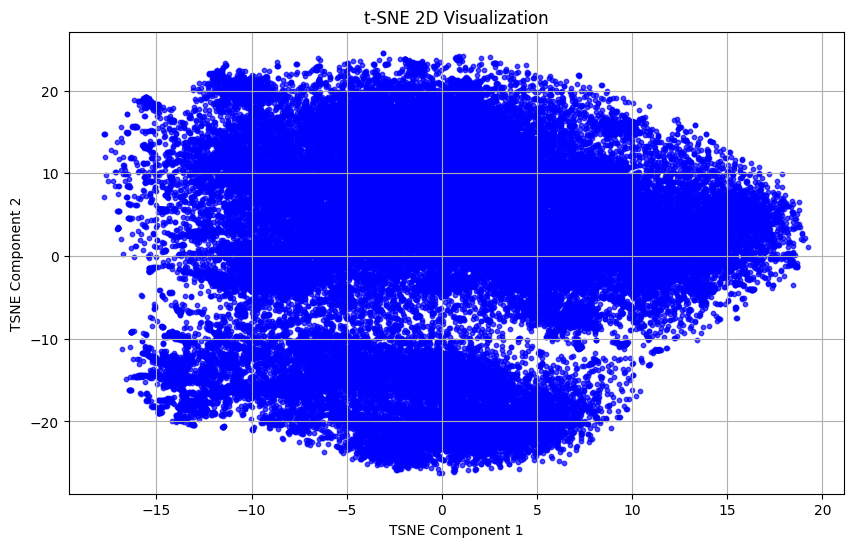

In [0]:
# Visualización de los datos reducidos
plt.figure(figsize=(10, 6))
plt.scatter(embedding_standard_4[:, 0], embedding_standard_4[:, 1], c='blue', marker='o', s=10, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE 2D Visualization')
plt.grid(True)
plt.show()

Using larger exaggeration: Exaggeration can be used in order to get better separation between clusters.

In [0]:
np.random.seed(0)
indices = np.random.permutation(list(range(X.shape[0])))
reverse = np.argsort(indices)
x_sample, x_rest = X[indices[:25000]], X[indices[25000:]]

In [0]:
sample_affinities = openTSNE.affinity.PerplexityBasedNN(
    x_sample,
    perplexity=800,
    n_jobs=32,
    random_state=0,
    verbose=True,
)

===> Finding 2400 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 68.40 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 5.75 seconds


In [0]:
sample_init = openTSNE.initialization.pca(x_sample, random_state=42)

In [0]:
sample_embedding = openTSNE.TSNE(n_jobs=32, verbose=True).fit(affinities=sample_affinities, initialization=sample_init)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=2083.33 for 250 iterations...
Iteration   50, KL divergence 3.1407, 50 iterations in 3.9925 sec
Iteration  100, KL divergence 3.1407, 50 iterations in 4.0691 sec
Iteration  150, KL divergence 3.1407, 50 iterations in 4.0666 sec
Iteration  200, KL divergence 3.1407, 50 iterations in 4.0422 sec
Iteration  250, KL divergence 3.1407, 50 iterations in 4.1041 sec
   --> Time elapsed: 20.28 seconds
===> Running optimization with exaggeration=1.00, lr=25000.00 for 500 iterations...
Iteration   50, KL divergence 1.9654, 50 iterations in 4.0594 sec
Iteration  100, KL divergence 1.9529, 50 iterations in 4.0914 sec
Iteration  150, KL divergence 1.9483, 50 iterations in 4.1183 sec
Iteration  200, KL divergence 1.9389, 50 iterations in

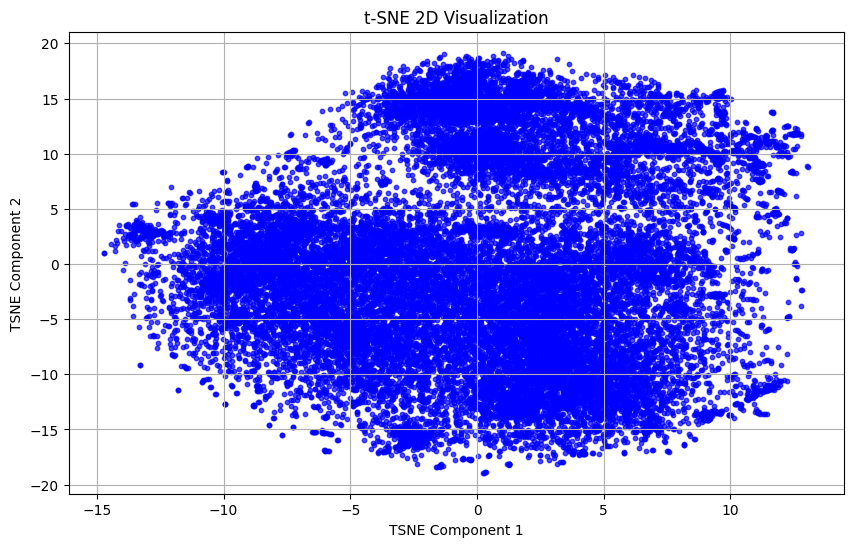

In [0]:
# Visualización de los datos reducidos
plt.figure(figsize=(10, 6))
plt.scatter(sample_embedding[:, 0], sample_embedding[:, 1], c='blue', marker='o', s=10, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE 2D Visualization')
plt.grid(True)
plt.show()

In [0]:
rest_init = sample_embedding.prepare_partial(x_rest, k=1, perplexity=1/3)

===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 10.42 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds


In [0]:
init_full = np.vstack((sample_embedding, rest_init))[reverse]

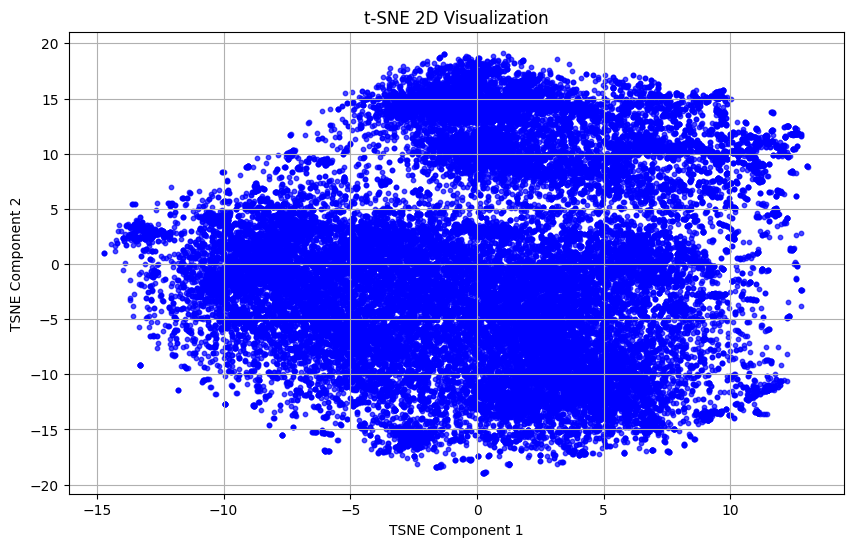

In [0]:
# Visualización de los datos reducidos
plt.figure(figsize=(10, 6))
plt.scatter(init_full[:, 0], init_full[:, 1], c='blue', marker='o', s=10, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE 2D Visualization')
plt.grid(True)
plt.show()

### UMAP

In [0]:
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=1)
embedding_umap = umap.fit_transform(X)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-55831853-847d-441a-925a-68a2833ce9df/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/local_disk0/.ephemeral_nfs/envs/pythonEnv-55831853-847d-441a-925a-68a2833ce9df/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


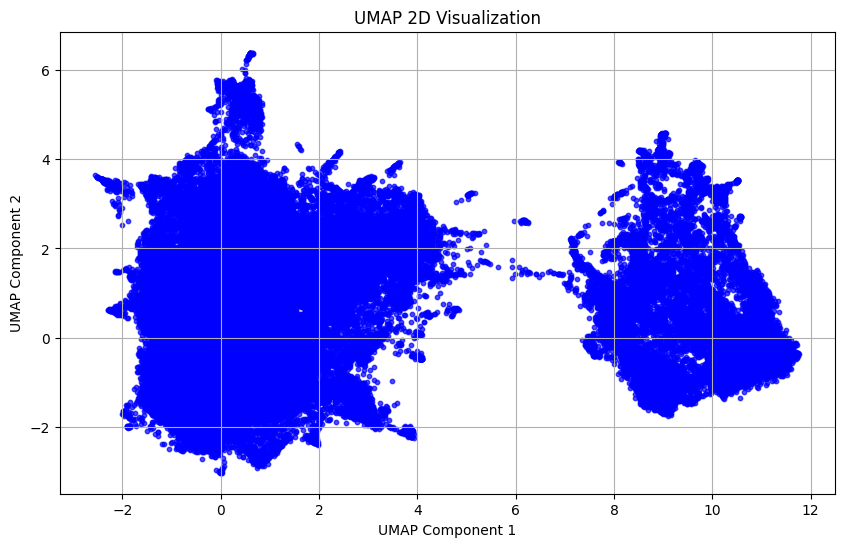

In [0]:
# Visualización de los datos reducidos
plt.figure(figsize=(10, 6))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c='blue', marker='o', s=10, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP 2D Visualization')
plt.grid(True)
plt.show()